In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/CECS551_Fianl_Project_Dataset/

/content/drive/My Drive/CECS551_Fianl_Project_Dataset


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro

In [ ]:
# Read DataFrame from different files
def readDataFrame():
  df = pd.read_csv('CECS551_dataset_02/sales_train_evaluation.csv')
  df_calendar = pd.read_csv('CECS551_dataset_02/calendar.csv')
  df_price = pd.read_csv('CECS551_dataset_02/sell_prices.csv')

  return df, df_calendar, df_price

df, df_calendar, df_price = readDataFrame()


In [ ]:
# Preprocess the Data from different files
def preProcessData(df, df_price):

  # from the csv file named 'sales_train_evaluation' we create our parameters
  COLS_ITM = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

  #we only study the first year (from day 1 to day 366)
  COLS_DATE = ['d_' + str(i) for i in range(1, 366)]

  # Change id to match with price dataframe (in file 'sell_prices' id is not mentioned as a feature)
  df['id'] = df['store_id'] + '-' + df['item_id']

  # Set our index
  df.set_index(COLS_ITM, inplace = True)

  # And the Scope of our study  = Year 1 (366 days)
  df = df[COLS_DATE]

  # convert days to Weeks to get the sale prices
  dict_week = dict(zip(df_calendar.d.values, df_calendar.wm_yr_wk.values))

  df_price['item_store_id'] = df_price['store_id'] + '-' + df_price['item_id']
  df_price.head()

  # Pricing
  df_price = df_price.pivot(index='item_store_id', columns='wm_yr_wk', values='sell_price').fillna(0)
  df_price.head()

  matrix_price = df_price.to_numpy()

  # Dict Matrix Index
  pr_n = dict(zip(df_price.index, range(len(df_price.index))))
  pr_p = dict(zip(df_price.columns, range(len(df_price.columns))))

  # we calculate the Sales Mean during the first 366 days
  df['mean'] = df[COLS_DATE].mean(axis = 1)

  # Standard Deviation
  df['std'] = df[COLS_DATE].std(axis = 1)

  # We remove items not sold during the first year
  #print("{:,} records for the full scope".format(len(df)))

  df = df[df['mean']>0]
  #print("{:,} records for after filter".format(len(df)))

  df.reset_index(inplace = True)
  # We verify that the line with product with zero sales in year 1 if they are deleted or not yet + Mean and standard dev columns

  # let's calculate the Total Units
  df['units'] = df[COLS_DATE].sum(axis = 1)

  # Turnover = Units x Price
  df['TO'] = 0 

  for col in COLS_DATE:
      df['TO'] = df['TO'] + df[col] * df[['id', col]].apply(lambda t: matrix_price[pr_n[t['id']], pr_p[dict_week[col]]], axis = 1)
      
  # We verify our updated columns
  df['CV'] = df['std']/df['mean']

  return df

df = preProcessData(df, df_price)


<ipython-input-115-a84779defe3a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean'] = df[COLS_DATE].mean(axis = 1)
<ipython-input-115-a84779defe3a>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std'] = df[COLS_DATE].std(axis = 1)


In [ ]:
# Prepare dataframe for each category such as HOUSEHOLD, HOBBIES, FOODS
def prepareDataFramePerCategory(df):

  # create a copy of our data frame where we focus only on 1 category (Hobbies)
  df_household = df[df['cat_id']=='HOUSEHOLD'].drop(['mean', 'std', 'CV'], axis = 1).copy()
  df_household = df_household.groupby(['item_id', 'dept_id', 'cat_id']).sum()

  df_hobbies = df[df['cat_id']=='HOBBIES'].drop(['mean', 'std', 'CV'], axis = 1).copy()
  df_hobbies = df_hobbies.groupby(['item_id', 'dept_id', 'cat_id']).sum()

  df_foods = df[df['cat_id']=='FOODS'].drop(['mean', 'std', 'CV'], axis = 1).copy()
  df_foods = df_foods.groupby(['item_id', 'dept_id', 'cat_id']).sum()

  return df_household, df_hobbies, df_foods

df_household, df_hobbies, df_foods = prepareDataFramePerCategory(df)


# ABC Analysis for Household category for one year 

In [ ]:
# Calculate Standard devation, Corelations of attributes
def calculateMeanSD(df_household):
  # Calculate mean - standard deviation - CV
  # Mean
  COLS_DATE = ['d_' + str(i) for i in range(1, 366)]

  df_household['mean'] = df_household[COLS_DATE].mean(axis = 1)

  # Filter out the reference withou sales
  df_household = df_household[df_household['mean']>0]

  # Standard
  df_household['std'] = df_household[COLS_DATE].std(axis = 1)

  # Coefficient of Variation
  df_household['CV'] = df_household['std']/df_household['mean']
  df_household.reset_index(inplace = True)

  # Normalility Test through Shapiro-wilks test
  df_household['Normality_p'] = df_household[COLS_DATE].apply(lambda row : stats.shapiro(row)[1], axis = 1)
  alpha = 0.001
  df_household['Not_Normal'] = df_household['Normality_p'] < alpha

  hobbies_index = df_household[df_household["item_id"].str.contains("HOUSEHOLD_1_323",  na=False)]
  return df_household

df_household = calculateMeanSD(df_household)
df_hobbies = calculateMeanSD(df_hobbies)
df_foods = calculateMeanSD(df_foods)


In [ ]:
# Calculate category as per value
def ABC_category(value):
    if value > 0 and value < 0.8:
        return 'A'
    elif value >= 0.8 and value < 0.95:
        return 'B'
    else:
        return 'C'
        
# Perform ABC analysis per data frame
def abcAnalysis(df_household):

  # ABC SKU-LEVEL
  COLS_DATE = ['d_' + str(i) for i in range(1, 366)]
  df_household = df_household.drop(COLS_DATE, axis =1).copy()
  df_household['TO%'] = 100*(df_household['TO']/(df_household['TO'].sum()))

  # Sort 
  df_household.sort_values(['TO%'], ascending = False, inplace = True, ignore_index=True)
  df_household['TO%_CS'] = df_household['TO%'].cumsum() #cumulated sum

  # A, B, C on SKU Number
  n_sku = len(df_household)
  n_a, n_b = int(0.05*n_sku), int(0.5*n_sku)
  df_household['SKU_ID'] = pd.Series(range(1, len(df_household))).astype(int)
  df_household['SKU_%'] = (100 * pd.Series(range(1, len(df_household))) / len(df_household))
  df_household['ABC'] = pd.Series(range(len(df_household))).apply(lambda t: 'A' if t <= n_a-1 else 'B' if t <= n_b-1 else 'C')

  # A, B, C on turnover
  to_a, to_b = df_household[df_household['SKU_ID']==n_a]['TO%'].max(), df_household[df_household['SKU_ID']==n_b]['TO%'].max()

  print("{:,} unique SKU".format(len(df_household)))

  return df_household, to_a, to_b

df_household, to_a, to_b = abcAnalysis(df_household)
df_hobbies, to_a_hobby, to_b_hobby = abcAnalysis(df_hobbies)
df_foods, to_a_foods, to_b_foods = abcAnalysis(df_foods)

# This method calculates the % of items making into category A, B & C
def calculateABCMetrics(df_household):
  dummyhouseHold = df_household.sort_values(by=['TO'], ascending=False)
  dummyhouseHold['RunCumCost'] = dummyhouseHold['TO'].cumsum()

  dummyhouseHold['TotalSum']  = dummyhouseHold['TO'].sum()
  dummyhouseHold['RunPerc']  = dummyhouseHold['RunCumCost'] / dummyhouseHold['TotalSum']

  dummyhouseHold['CLASS'] = dummyhouseHold['RunPerc'].apply(ABC_category)

  print ('Cost of Class A :', dummyhouseHold[dummyhouseHold.CLASS == 'A']['TO'].sum())
  print ('Cost of Class B :', dummyhouseHold[dummyhouseHold.CLASS == 'B']['TO'].sum())
  print ('Cost of Class C :', dummyhouseHold[dummyhouseHold.CLASS == 'C']['TO'].sum())

  print ('Percent of Cost of Class A :', dummyhouseHold[dummyhouseHold.CLASS == 'A']['TO'].sum()/dummyhouseHold['TO'].sum())
  print ('Percent of Cost of Class B :', dummyhouseHold[dummyhouseHold.CLASS == 'B']['TO'].sum()/dummyhouseHold['TO'].sum())
  print ('Percent of Cost of Class C :', dummyhouseHold[dummyhouseHold.CLASS == 'C']['TO'].sum()/dummyhouseHold['TO'].sum())

calculateABCMetrics(df_household)

649 unique SKU
317 unique SKU
912 unique SKU
Cost of Class A : 5972687.670000002
Cost of Class B : 1122231.7800000012
Cost of Class C : 376338.1000000001
Percent of Cost of Class A : 0.79942200225717
Percent of Cost of Class B : 0.15020654454617222
Percent of Cost of Class C : 0.05037145319665762


# Plot graph for ABC analysis for household category

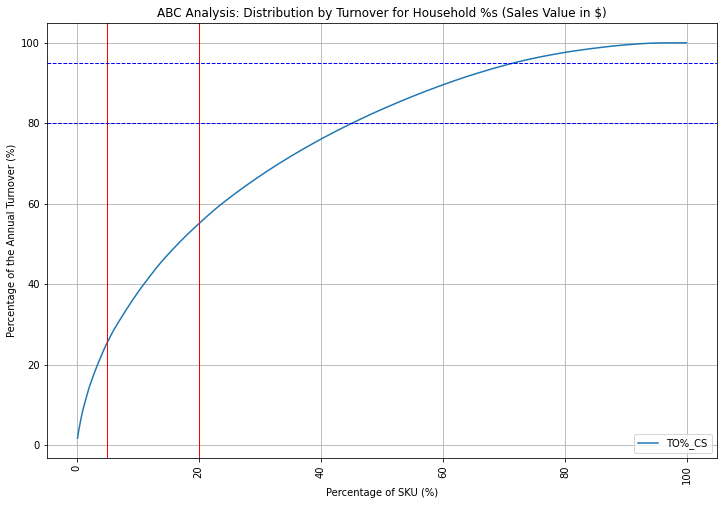

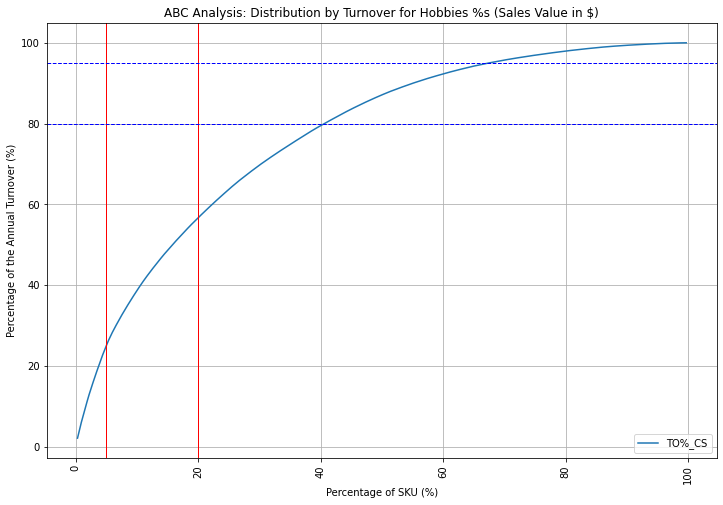

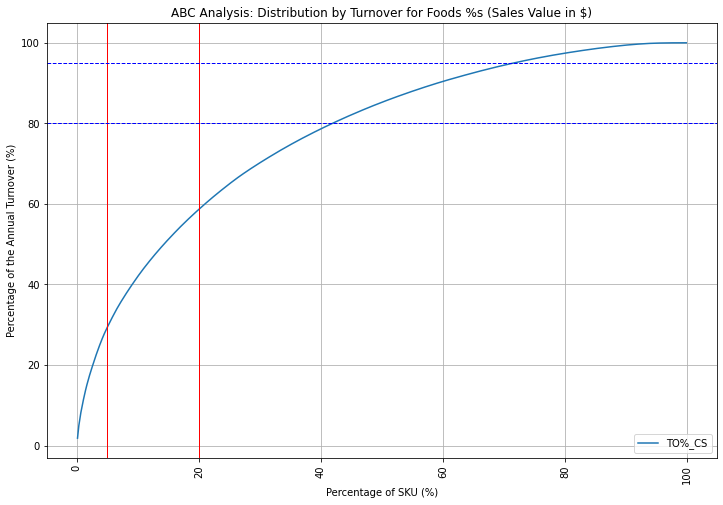

In [ ]:
def abcPlotGraph(df_household, desc):
  # Distribution by Value
  ax = plt.gca()
  df_household.plot(figsize=(12, 8), x='SKU_%', y='TO%_CS', ax=ax, grid = True)

  # ABC
  # 20%, 50% of SKU Number (2 Vertical lines)

  ax.axvline(5 , color="red", linestyle="-", linewidth = 1.0)
  ax.axvline(20 , color="red", linestyle="-", linewidth = 1.0)

  # 20%, 50% of SKU Number (2 Horizental lines)
  ax.axhline(80 , color="blue", linestyle="--", linewidth = 1.0)
  ax.axhline(95 , color="blue", linestyle="--", linewidth = 1.0)

  plt.xlabel('Percentage of SKU (%)')
  plt.xticks(rotation=90)
  plt.ylabel('Percentage of the Annual Turnover (%)')

  plt.title('ABC Analysis: Distribution by Turnover for {0} %s (Sales Value in $)'.format(desc))
  plt.show()
  return df_household

df_household = abcPlotGraph(df_household, "Household")
df_hobbies = abcPlotGraph(df_hobbies, "Hobbies")
df_foods = abcPlotGraph(df_foods, "Foods")

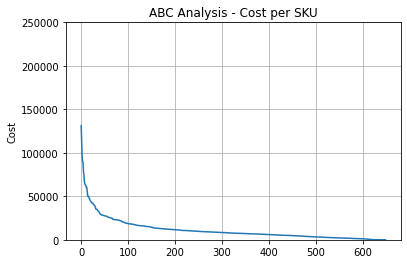

In [ ]:
performance = df_household['TO'].tolist()
y_pos = np.arange(len(performance))

plt.plot(y_pos, performance)
plt.ylabel('Cost')
plt.title('ABC Analysis - Cost per SKU')
plt.grid(True)
plt.ylim((0,250000))
plt.show()

# Co efficient of variation for different categories

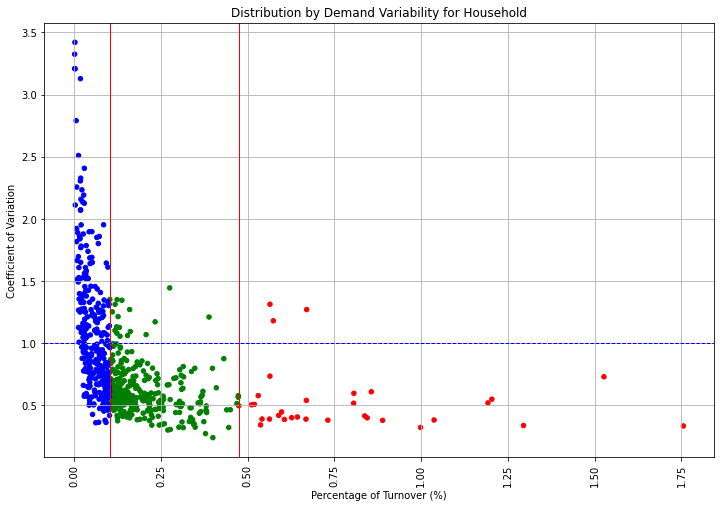

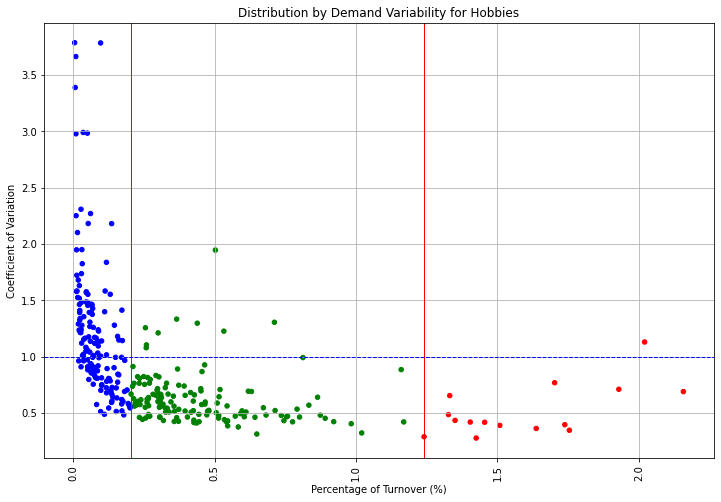

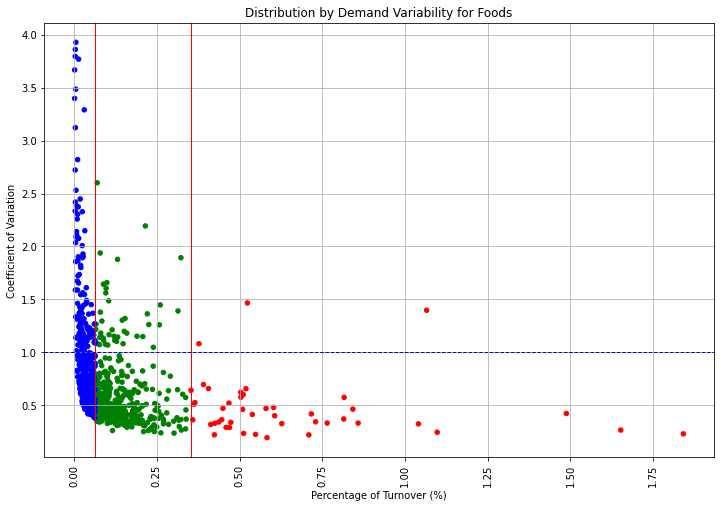

In [ ]:
def barPlot(df_household, to_a, to_b, desc):
  # Bar Chart
  ax = plt.gca()
  colors = {'A':'red', 'B':'green', 'C':'blue'}

  # Remove Outliers
  df_plot = df_household[df_household['CV']<4].copy()
  df_plot.plot.scatter(figsize=(12, 8), x='TO%', y='CV', color=df_plot['ABC'].map(colors), ax =ax, grid = True)

  # ABC
  # A, B and C
  ax.axvline(to_a , color="red", linestyle="-", linewidth = 1.0)
  ax.axvline(to_b , color="red", linestyle="-", linewidth = 1.0)

  # 20%, 50% of SKU Number
  ax.axhline(1 , color="blue", linestyle="--", linewidth = 1.0)

  plt.xlabel('Percentage of Turnover (%)')
  plt.xticks(rotation=90)
  plt.ylabel('Coefficient of Variation')

  plt.title('Distribution by Demand Variability for {0}'.format(desc))
  plt.show()

  return df_household, df_plot

df_household, df_plot = barPlot(df_household, to_a, to_b, "Household")
df_hobbies, df_plot_hobby = barPlot(df_hobbies, to_a_hobby, to_b_hobby, "Hobbies")
df_foods, df_plot_foods = barPlot(df_foods, to_a_foods, to_b_foods, "Foods")


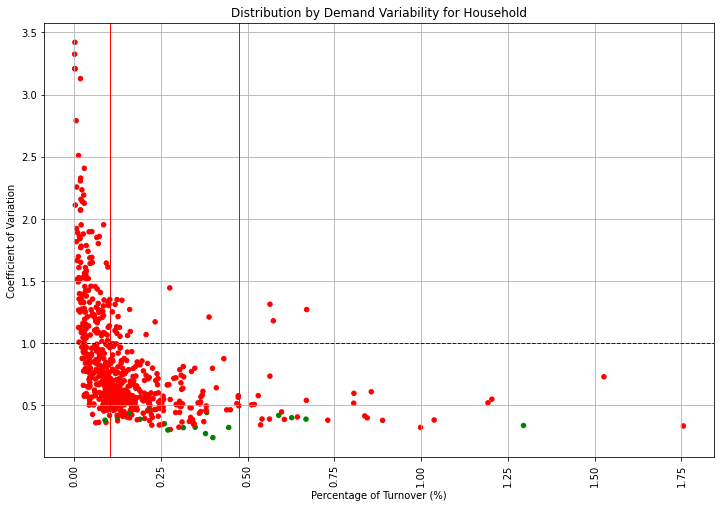

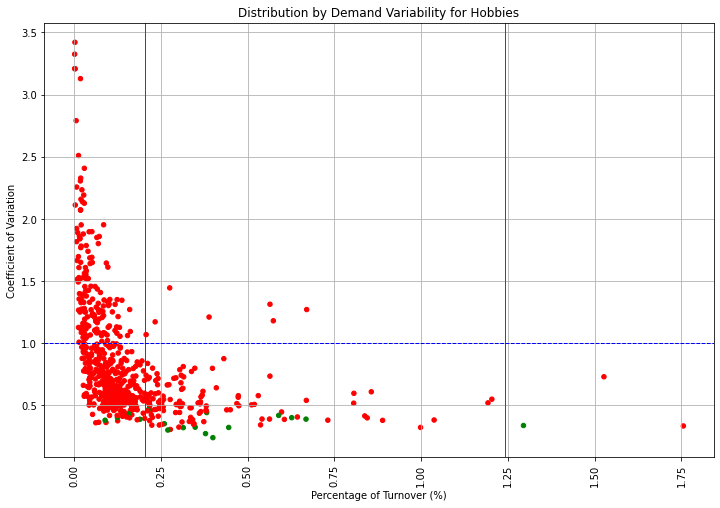

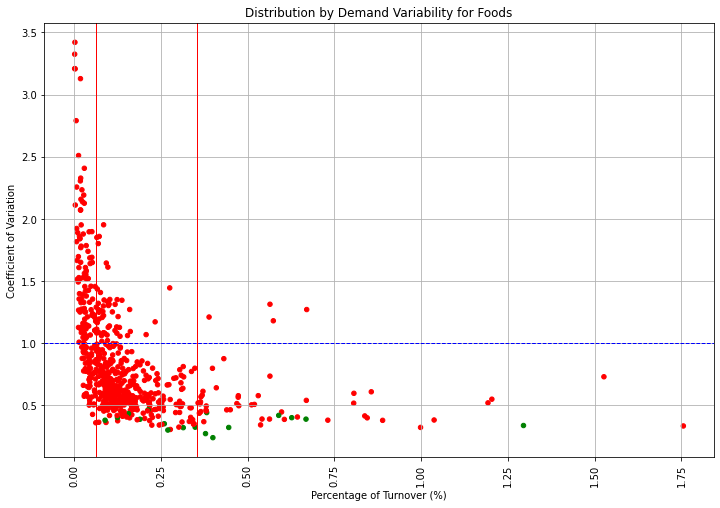

In [ ]:
def barPlot2(df_plot, to_a, to_b, desc):
  # Bar Chart
  ax = plt.gca()
  colors = {False:'green', True:'red'}

  # Remove Outliers
  df_plot = df_household[df_household['CV']<4].copy()
  df_plot.plot.scatter(figsize=(12, 8), x='TO%', y='CV', color=df_plot['Not_Normal'].map(colors), ax =ax, grid = True)

  # ABC
  # A, B and C
  ax.axvline(to_a , color="red", linestyle="-", linewidth = 1.0)
  ax.axvline(to_b , color="red", linestyle="-", linewidth = 1.0)

  # 20%, 50% of SKU Number

  ax.axhline(1 , color="blue", linestyle="--", linewidth = 1.0)

  plt.xlabel('Percentage of Turnover (%)')
  plt.xticks(rotation=90)

  plt.ylabel('Coefficient of Variation')
  plt.title('Distribution by Demand Variability for {0}'.format(desc))

  plt.show()

barPlot2(df_plot, to_a, to_b, "Household")
barPlot2(df_plot_hobby, to_a_hobby, to_b_hobby, "Hobbies")
barPlot2(df_plot_foods, to_a_foods, to_b_foods, "Foods")

Coefficient of variation for different categories